In [ ]:
!pip install torch torchvision opencv-python matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 762.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
!python3 --version

Python 3.11.12


In [ ]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from skimage import exposure

class CrackDataset(Dataset):
    def __init__(self, input_dir, output_dir, target_size=(256, 256), transform=None):
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.input_files = sorted(os.listdir(input_dir))
        self.output_files = sorted(os.listdir(output_dir))
        self.target_size = target_size
        self.transform = transform

        # Verify matching file pairs
        assert len(self.input_files) == len(self.output_files), "Number of input and output files don't match!"

        # Extract metadata (notch length and position) from filenames if available
        self.metadata = []
        for filename in self.input_files:
            # Assuming filename format contains notch info like "notch_50mm_25mm.png"
            # Modify this based on your actual filename format
            try:
                parts = filename.split('_')
                if len(parts) >= 3:
                    notch_length = float(parts[1].replace('mm', ''))
                    notch_position = float(parts[2].replace('mm', '').split('.')[0])
                else:
                    notch_length = 50.0  # Default from problem statement
                    notch_position = 0.0  # Default left corner

                self.metadata.append({
                    'notch_length': notch_length / 100.0,  # Normalize to [0,1] range
                    'notch_position': notch_position / 100.0  # Normalize to [0,1] range
                })
            except:
                # If parsing fails, use default values
                self.metadata.append({
                    'notch_length': 0.5,  # 50mm normalized
                    'notch_position': 0.0  # Default left corner
                })

    def __len__(self):
        return len(self.input_files)

    def enhance_crack_visibility(self, img):
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Apply contrast enhancement
        enhanced = exposure.equalize_adapthist(gray)

        # Convert back to 3-channel format
        enhanced_rgb = np.stack([enhanced, enhanced, enhanced], axis=-1)
        return enhanced_rgb

    def __getitem__(self, idx):
        input_path = os.path.join(self.input_dir, self.input_files[idx])
        output_path = os.path.join(self.output_dir, self.output_files[idx])

        # Read images
        input_img = cv2.imread(input_path, cv2.IMREAD_COLOR)
        output_img = cv2.imread(output_path, cv2.IMREAD_COLOR)

        # Convert from BGR to RGB
        input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
        output_img = cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)

        # Enhance crack visibility
        input_enhanced = self.enhance_crack_visibility(input_img)
        output_enhanced = self.enhance_crack_visibility(output_img)

        # Extract the crack segmentation mask
        # This assumes cracks appear reddish in the output images
        # Adjust the thresholds based on your data
        output_red_channel = output_img[:,:,0]
        crack_mask = np.zeros_like(output_red_channel)
        crack_mask[output_red_channel > 200] = 1.0

        # Resize images
        input_img = cv2.resize(input_enhanced, self.target_size)
        output_img = cv2.resize(output_enhanced, self.target_size)
        crack_mask = cv2.resize(crack_mask, self.target_size)

        # Normalize to [0,1]
        input_img = input_img.astype('float32') / 255.0
        output_img = output_img.astype('float32') / 255.0

        # Convert to tensor format (CHW)
        input_img = np.transpose(input_img, (2, 0, 1))
        output_img = np.transpose(output_img, (2, 0, 1))

        # Get metadata
        metadata = self.metadata[idx]

        return {
            'input': torch.tensor(input_img, dtype=torch.float32),
            'output': torch.tensor(output_img, dtype=torch.float32),
            'crack_mask': torch.tensor(crack_mask, dtype=torch.float32).unsqueeze(0),
            'filename': self.input_files[idx],
            'notch_length': torch.tensor(metadata['notch_length'], dtype=torch.float32),
            'notch_position': torch.tensor(metadata['notch_position'], dtype=torch.float32)
        }

    def visualize_sample(self, idx):
        sample = self[idx]

        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        input_img = sample['input'].numpy().transpose(1, 2, 0)
        plt.imshow(input_img)
        plt.title(f"Input (NL: {sample['notch_length'].item()*100:.1f}mm, NP: {sample['notch_position'].item()*100:.1f}mm)")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        output_img = sample['output'].numpy().transpose(1, 2, 0)
        plt.imshow(output_img)
        plt.title("Ground Truth Output")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        crack_mask = sample['crack_mask'].numpy()[0]
        plt.imshow(crack_mask, cmap='hot')
        plt.title("Crack Mask")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionBlock(nn.Module):
    def __init__(self, in_channels):
        super(AttentionBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        attention = self.conv(x)
        attention = self.sigmoid(attention)
        return x * attention.expand_as(x)

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class EnhancedUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(EnhancedUNet, self).__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.attention_blocks = nn.ModuleList()

        # Encoder
        for feature in features:
            self.encoder.append(ConvBlock(in_channels, feature))
            in_channels = feature

        # Bottleneck
        self.bottleneck = ConvBlock(features[-1], features[-1]*2)
        bottleneck_size = features[-1]*2  # Store this for metadata integration

        # Metadata integration - adjusted to match bottleneck size
        self.metadata_fc = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, bottleneck_size)  # Match bottleneck feature dimension
        )

        # Decoder with skip connections
        for feature in reversed(features):
            self.decoder.append(
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.decoder.append(ConvBlock(feature*2, feature))
            self.attention_blocks.append(AttentionBlock(feature))

        # Final output
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x, metadata):
        # x shape: [batch_size, channels, height, width]
        # metadata shape: [batch_size, 2] (notch_length, notch_position)

        skip_connections = []

        # Print shape info during first forward pass for debugging
        debug = False

        # Encoder path
        for i, enc in enumerate(self.encoder):
            x = enc(x)
            if debug:
                print(f"Encoder {i} output shape: {x.shape}")
            skip_connections.append(x)
            x = self.pool(x)

        # Bottleneck
        x = self.bottleneck(x)
        if debug:
            print(f"Bottleneck output shape: {x.shape}")

        # Integrate metadata
        batch_size, channels, h, w = x.shape
        metadata_features = self.metadata_fc(metadata)  # [batch_size, bottleneck_size]
        if debug:
            print(f"Metadata features shape: {metadata_features.shape}")

        # Reshape metadata features to match bottleneck spatial dimensions
        metadata_features = metadata_features.view(batch_size, channels, 1, 1).expand(-1, -1, h, w)
        if debug:
            print(f"Reshaped metadata features shape: {metadata_features.shape}")

        # Add metadata features to bottleneck features
        x = x + 0.1 * metadata_features  # Reduced influence with 0.1 scaling factor

        # Decoder path with skip connections
        skip_connections = skip_connections[::-1]  # Reverse for easier access

        for idx in range(0, len(self.decoder), 2):
            x = self.decoder[idx](x)  # Upsample
            if debug:
                print(f"Decoder upsampled {idx} shape: {x.shape}")

            skip = skip_connections[idx//2]
            if debug:
                print(f"Skip connection {idx//2} shape: {skip.shape}")

            # Apply attention to skip connection
            attended_skip = self.attention_blocks[idx//2](skip)

            # Handle different sizes
            if x.shape != attended_skip.shape:
                x = F.interpolate(x, size=attended_skip.shape[2:])
                if debug:
                    print(f"After interpolation shape: {x.shape}")

            concat_skip = torch.cat((attended_skip, x), dim=1)
            if debug:
                print(f"After concat shape: {concat_skip.shape}")

            x = self.decoder[idx+1](concat_skip)
            if debug:
                print(f"Decoder block {idx+1} output shape: {x.shape}")

        # Final output
        return torch.sigmoid(self.final_conv(x))

# Instantiate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EnhancedUNet(in_channels=3, out_channels=1).to(device)

# Print model summary to check architecture
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model has {count_parameters(model):,} trainable parameters")

Model has 31,111,237 trainable parameters


In [ ]:
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Mixed loss function for better crack path prediction
class CrackLoss(nn.Module):
    def __init__(self, dice_weight=0.5, bce_weight=0.5):
        super(CrackLoss, self).__init__()
        self.dice_weight = dice_weight
        self.bce_weight = bce_weight
        self.bce_loss = nn.BCELoss()

    def dice_coef(self, y_pred, y_true, smooth=1.0):
        y_pred_flat = y_pred.view(-1)
        y_true_flat = y_true.view(-1)
        intersection = (y_pred_flat * y_true_flat).sum()
        return (2. * intersection + smooth) / (y_pred_flat.sum() + y_true_flat.sum() + smooth)

    def dice_loss(self, y_pred, y_true):
        return 1 - self.dice_coef(y_pred, y_true)

    def forward(self, y_pred, y_true):
        dice = self.dice_loss(y_pred, y_true)
        bce = self.bce_loss(y_pred, y_true)
        return self.bce_weight * bce + self.dice_weight * dice

# Setup dataset and dataloader
# Ensure these directories exist
input_dir = '/content/drive/MyDrive/Data/input'
output_dir = '/content/drive/MyDrive/Data/output'
dataset = CrackDataset(input_dir, output_dir, target_size=(256, 256))

# Print dataset size
print(f"Dataset size: {len(dataset)} samples")

# Try fetching a sample to make sure dataset works
try:
    sample = dataset[0]
    print("Successfully loaded a sample from dataset")
    print(f"Input shape: {sample['input'].shape}")
    print(f"Output shape: {sample['output'].shape}")
    print(f"Crack mask shape: {sample['crack_mask'].shape}")
    print(f"Metadata: notch_length={sample['notch_length']}, position={sample['notch_position']}")
except Exception as e:
    print(f"Error loading sample: {e}")

# Split into train and validation sets
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 4  # Reduced from 8 to avoid potential memory issues
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Verify dataloader works
try:
    batch = next(iter(train_loader))
    print("Successfully loaded a batch from dataloader")
    print(f"Batch input shape: {batch['input'].shape}")
    print(f"Batch metadata shape: {torch.stack([batch['notch_length'], batch['notch_position']], dim=1).shape}")
except Exception as e:
    print(f"Error loading batch: {e}")

# Setup model, loss function, optimizer, and scheduler
model = EnhancedUNet(in_channels=3, out_channels=1).to(device)
criterion = CrackLoss(dice_weight=0.7, bce_weight=0.3)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)

# Training loop with additional error handling
num_epochs = 5
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0

    for batch_idx, batch in enumerate(train_loader):
        try:
            inputs = batch['input'].to(device)
            crack_masks = batch['crack_mask'].to(device)
            metadata = torch.stack([batch['notch_length'], batch['notch_position']], dim=1).to(device)

            # Print shapes for first batch of first epoch for debugging
            if epoch == 0 and batch_idx == 0:
                print(f"Input shape: {inputs.shape}")
                print(f"Crack mask shape: {crack_masks.shape}")
                print(f"Metadata shape: {metadata.shape}")

            optimizer.zero_grad()
            outputs = model(inputs, metadata)

            if epoch == 0 and batch_idx == 0:
                print(f"Output shape: {outputs.shape}")

            loss = criterion(outputs, crack_masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

            # Print batch progress every 10 batches
            if batch_idx % 10 == 0:
                print(f"Epoch {epoch+1}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")

        except Exception as e:
            print(f"Error in batch {batch_idx}: {e}")
            continue

    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            try:
                inputs = batch['input'].to(device)
                crack_masks = batch['crack_mask'].to(device)
                metadata = torch.stack([batch['notch_length'], batch['notch_position']], dim=1).to(device)

                outputs = model(inputs, metadata)
                loss = criterion(outputs, crack_masks)

                val_loss += loss.item() * inputs.size(0)
            except Exception as e:
                print(f"Error in validation: {e}")
                continue

        val_loss /= len(val_loader.dataset)

    # Update learning rate
    scheduler.step(val_loss)

    # Print status
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Save model if it's the best so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_val_loss,
        }, 'best_crack_model.pth')
        print(f"Model saved at epoch {epoch+1} with val_loss: {val_loss:.4f}")

    # Early stopping condition
    if epoch > 10 and optimizer.param_groups[0]['lr'] < 1e-5:
        print("Early stopping due to learning rate reduction")
        break

Dataset size: 49 samples
Successfully loaded a sample from dataset
Input shape: torch.Size([3, 256, 256])
Output shape: torch.Size([3, 256, 256])
Crack mask shape: torch.Size([1, 256, 256])
Metadata: notch_length=0.14000000059604645, position=0.0
Successfully loaded a batch from dataloader
Batch input shape: torch.Size([4, 3, 256, 256])
Batch metadata shape: torch.Size([4, 2])
Input shape: torch.Size([4, 3, 256, 256])
Crack mask shape: torch.Size([4, 1, 256, 256])
Metadata shape: torch.Size([4, 2])
Output shape: torch.Size([4, 1, 256, 256])
Epoch 1, Batch 0/10, Loss: 0.7100
Epoch [1/5], Train Loss: 0.3667, Val Loss: 0.6784
Model saved at epoch 1 with val_loss: 0.6784
Epoch 2, Batch 0/10, Loss: 0.2843
Epoch [2/5], Train Loss: 0.2678, Val Loss: 0.6891
Epoch 3, Batch 0/10, Loss: 0.2459
Epoch [3/5], Train Loss: 0.2302, Val Loss: 0.7089
Epoch 4, Batch 0/10, Loss: 0.2106
Epoch [4/5], Train Loss: 0.1960, Val Loss: 0.7194
Epoch 5, Batch 0/10, Loss: 0.1779
Epoch [5/5], Train Loss: 0.1649, Val L

Testing dataset visualization:


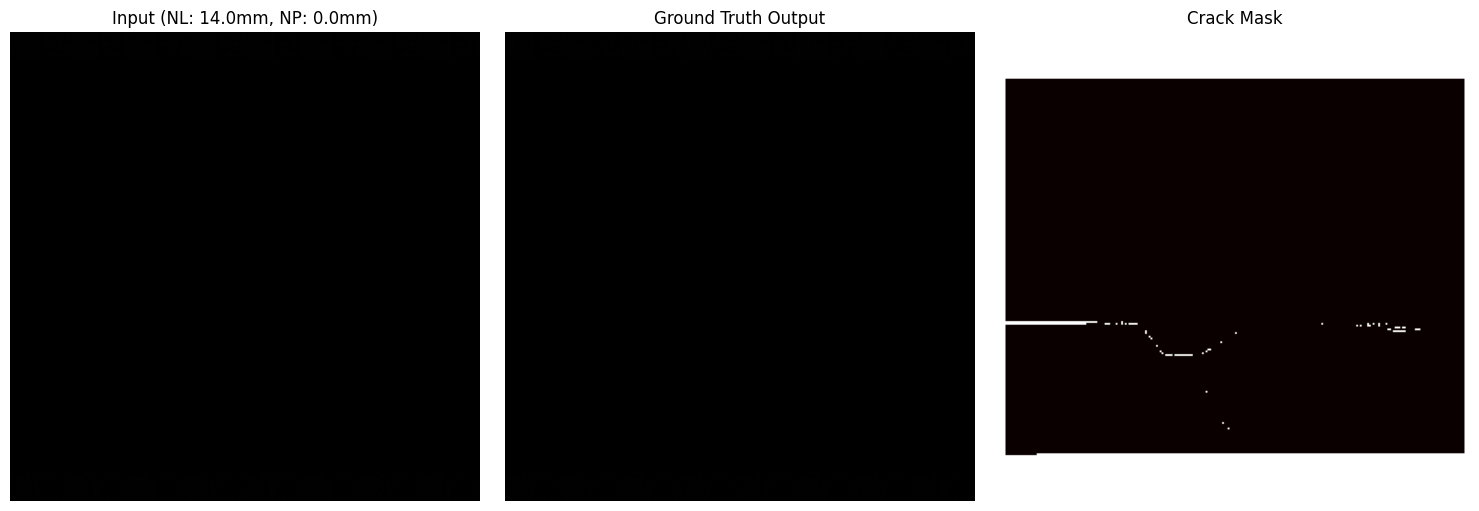

In [ ]:
# Visualization test
def test_dataset_visualization():
    print("Testing dataset visualization:")
    sample_idx = 0
    sample = dataset[sample_idx]

    import matplotlib.pyplot as plt

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    input_img = sample['input'].numpy().transpose(1, 2, 0)
    plt.imshow(input_img)
    plt.title(f"Input (NL: {sample['notch_length'].item()*100:.1f}mm, NP: {sample['notch_position'].item()*100:.1f}mm)")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    output_img = sample['output'].numpy().transpose(1, 2, 0)
    plt.imshow(output_img)
    plt.title("Ground Truth Output")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    crack_mask = sample['crack_mask'].numpy()[0]
    plt.imshow(crack_mask, cmap='hot')
    plt.title("Crack Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Run visualization test
test_dataset_visualization()

Dataset size: 49 samples


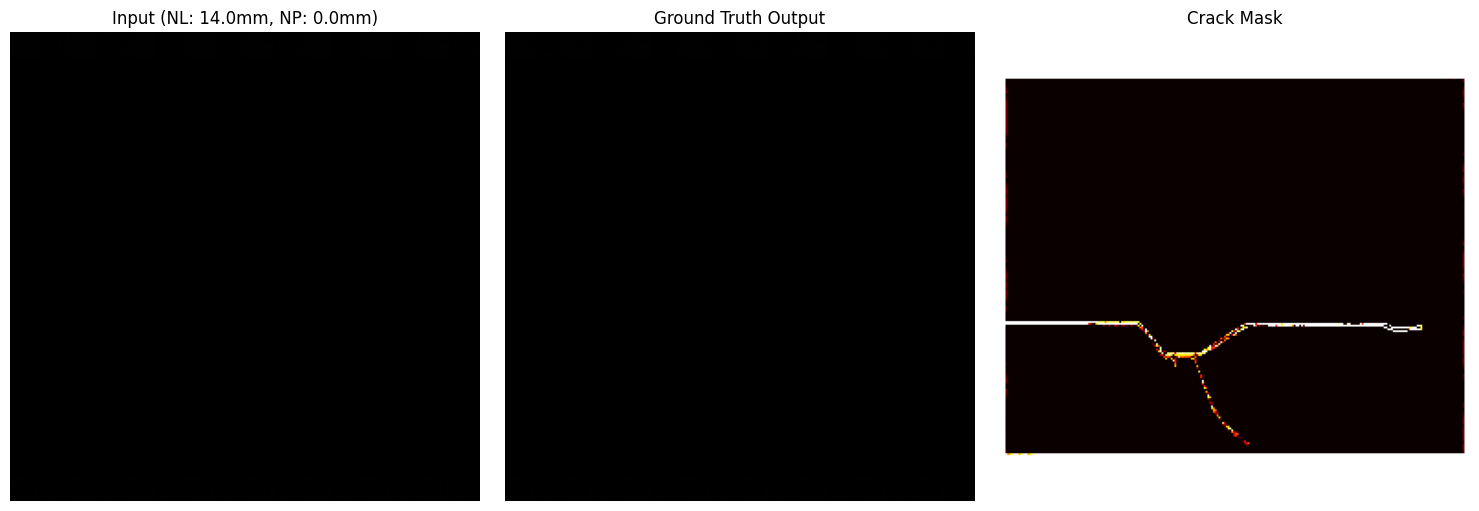

Model has 31,111,237 trainable parameters
Epoch 1, Batch 0/10, Loss: 0.7135
Epoch [1/200], Train Loss: 0.3879, Val Loss: 0.6785
Model saved at epoch 1 with val_loss: 0.6785
Epoch 2, Batch 0/10, Loss: 0.3028
Epoch [2/200], Train Loss: 0.2825, Val Loss: 0.6967
Epoch 3, Batch 0/10, Loss: 0.2582
Epoch [3/200], Train Loss: 0.2408, Val Loss: 0.7184
Epoch 4, Batch 0/10, Loss: 0.2183
Epoch [4/200], Train Loss: 0.2034, Val Loss: 0.7407
Epoch 5, Batch 0/10, Loss: 0.1842
Epoch [5/200], Train Loss: 0.1703, Val Loss: 0.7503
Epoch 6, Batch 0/10, Loss: 0.1539
Epoch [6/200], Train Loss: 0.1420, Val Loss: 0.7581
Epoch 7, Batch 0/10, Loss: 0.1282
Epoch [7/200], Train Loss: 0.1186, Val Loss: 0.7426
Epoch 8, Batch 0/10, Loss: 0.1067
Epoch [8/200], Train Loss: 0.1032, Val Loss: 0.6666
Model saved at epoch 8 with val_loss: 0.6666
Epoch 9, Batch 0/10, Loss: 0.0984
Epoch [9/200], Train Loss: 0.0949, Val Loss: 0.3946
Model saved at epoch 9 with val_loss: 0.3946
Epoch 10, Batch 0/10, Loss: 0.0903
Epoch [10/200]

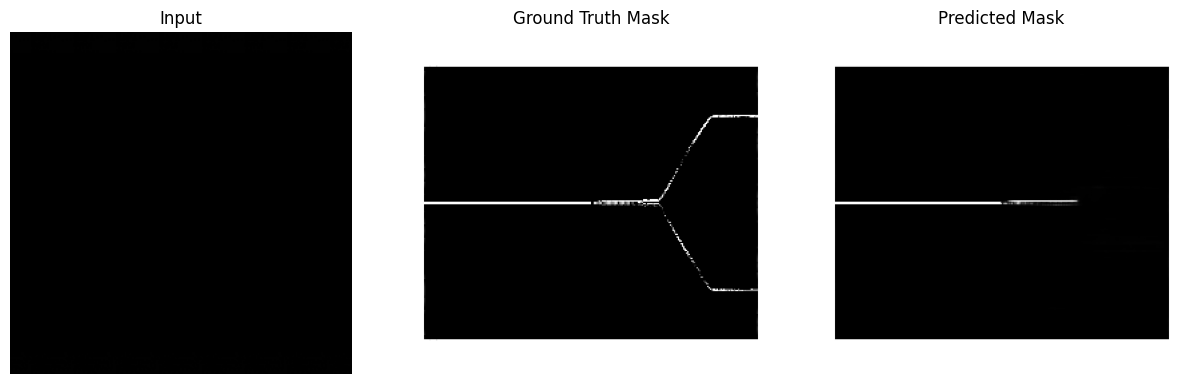

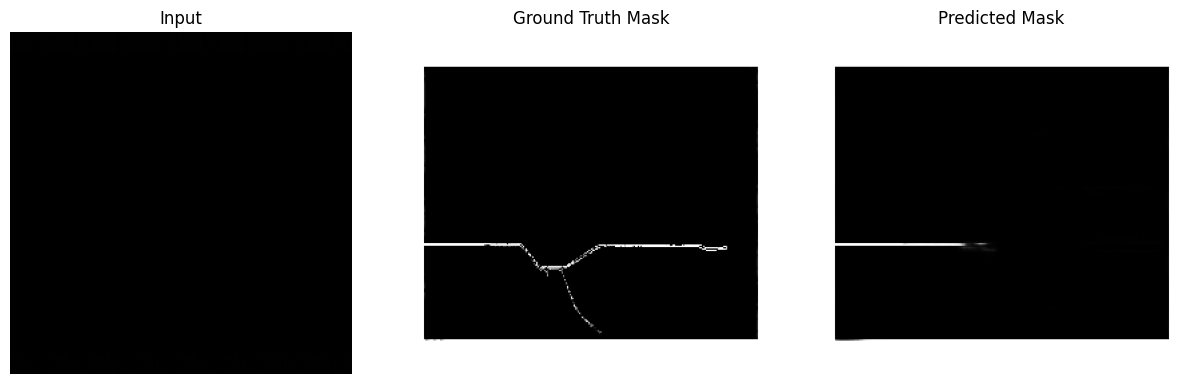

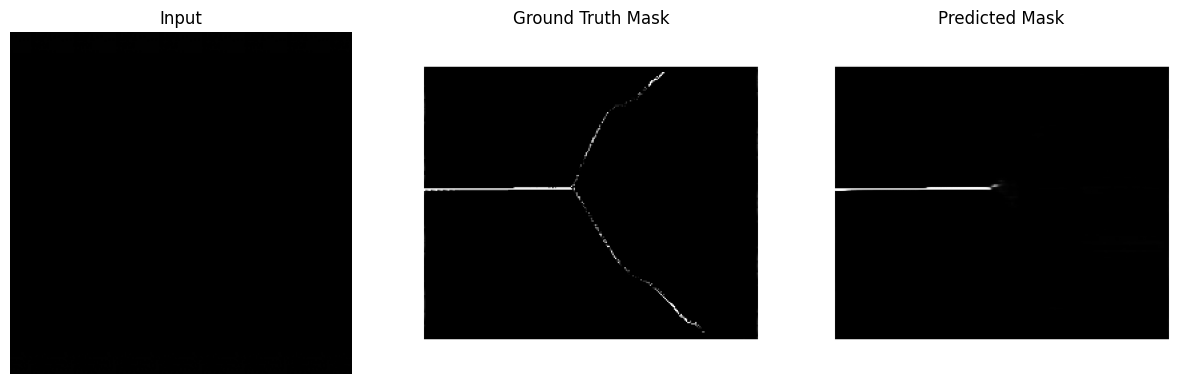

Validation Dice Coefficient: 0.9905


In [ ]:
# =========================
# Complete Code for Crack Detection with EnhancedUNet
# =========================

# 1. Import required libraries
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
from skimage import exposure

# 2. Define the custom dataset class
class CrackDataset(Dataset):
    def __init__(self, input_dir, output_dir, target_size=(256, 256), transform=None):
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.input_files = sorted(os.listdir(input_dir))
        self.output_files = sorted(os.listdir(output_dir))
        self.target_size = target_size
        self.transform = transform

        # Verify matching file pairs
        assert len(self.input_files) == len(self.output_files), "Number of input and output files don't match!"

        # Extract metadata (e.g., notch length and position) from filenames if available
        self.metadata = []
        for filename in self.input_files:
            # Assuming filename format contains notch info like "notch_50mm_25mm.png"
            # Modify this based on your actual filename format
            try:
                parts = filename.split('_')
                if len(parts) >= 3:
                    notch_length = float(parts[1].replace('mm', ''))
                    notch_position = float(parts[2].replace('mm', '').split('.')[0])
                else:
                    notch_length = 50.0  # Default from problem statement
                    notch_position = 0.0  # Default left corner

                self.metadata.append({
                    'notch_length': notch_length / 100.0,  # Normalize to [0,1]
                    'notch_position': notch_position / 100.0  # Normalize to [0,1]
                })
            except:
                # If parsing fails, use default values
                self.metadata.append({
                    'notch_length': 0.5,   # 50mm normalized
                    'notch_position': 0.0  # Default left corner
                })

    def __len__(self):
        return len(self.input_files)

    def enhance_crack_visibility(self, img):
        # Convert to grayscale, apply contrast enhancement, then re-stack to 3 channels
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        enhanced = exposure.equalize_adapthist(gray)
        enhanced_rgb = np.stack([enhanced, enhanced, enhanced], axis=-1)
        return enhanced_rgb

    def __getitem__(self, idx):
        input_path = os.path.join(self.input_dir, self.input_files[idx])
        output_path = os.path.join(self.output_dir, self.output_files[idx])

        # Read images in color
        input_img = cv2.imread(input_path, cv2.IMREAD_COLOR)
        output_img = cv2.imread(output_path, cv2.IMREAD_COLOR)

        # Convert BGR to RGB
        input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
        output_img = cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)

        # Enhance crack visibility in both images
        input_enhanced = self.enhance_crack_visibility(input_img)
        output_enhanced = self.enhance_crack_visibility(output_img)

        # Extract crack segmentation mask from the output image.
        # Adjust the threshold if necessary. Here, it assumes cracks are bright in the red channel.
        output_red_channel = output_img[:,:,0]
        crack_mask = np.zeros_like(output_red_channel, dtype=np.float32)
        crack_mask[output_red_channel > 150] = 1.0  # threshold chosen empirically

        # Resize images and crack mask
        input_img = cv2.resize(input_enhanced, self.target_size)
        output_img = cv2.resize(output_enhanced, self.target_size)
        crack_mask = cv2.resize(crack_mask, self.target_size)

        # Normalize to [0,1]
        input_img = input_img.astype('float32') / 255.0
        output_img = output_img.astype('float32') / 255.0

        # Convert images to tensor format (CHW)
        input_img = np.transpose(input_img, (2, 0, 1))
        output_img = np.transpose(output_img, (2, 0, 1))

        # Get metadata for the sample
        metadata = self.metadata[idx]

        return {
            'input': torch.tensor(input_img, dtype=torch.float32),
            'output': torch.tensor(output_img, dtype=torch.float32),
            'crack_mask': torch.tensor(crack_mask, dtype=torch.float32).unsqueeze(0),
            'filename': self.input_files[idx],
            'notch_length': torch.tensor(metadata['notch_length'], dtype=torch.float32),
            'notch_position': torch.tensor(metadata['notch_position'], dtype=torch.float32)
        }

    def visualize_sample(self, idx):
        sample = self[idx]
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        input_img = sample['input'].numpy().transpose(1, 2, 0)
        plt.imshow(input_img)
        plt.title(f"Input (NL: {sample['notch_length'].item()*100:.1f}mm, NP: {sample['notch_position'].item()*100:.1f}mm)")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        output_img = sample['output'].numpy().transpose(1, 2, 0)
        plt.imshow(output_img)
        plt.title("Ground Truth Output")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        crack_mask = sample['crack_mask'].numpy()[0]
        plt.imshow(crack_mask, cmap='hot')
        plt.title("Crack Mask")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

# 3. Define the Enhanced U-Net model with Attention & Metadata Integration
class AttentionBlock(nn.Module):
    def __init__(self, in_channels):
        super(AttentionBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        attention = self.conv(x)
        attention = self.sigmoid(attention)
        return x * attention.expand_as(x)

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class EnhancedUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(EnhancedUNet, self).__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.attention_blocks = nn.ModuleList()

        # Encoder
        for feature in features:
            self.encoder.append(ConvBlock(in_channels, feature))
            in_channels = feature

        # Bottleneck
        self.bottleneck = ConvBlock(features[-1], features[-1]*2)
        bottleneck_size = features[-1]*2  # for metadata integration

        # Metadata integration: Transform 2 metadata features to match bottleneck channels
        self.metadata_fc = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, bottleneck_size)  # Output dimensionality equals bottleneck channels
        )

        # Decoder with skip connections and attention blocks
        for feature in reversed(features):
            self.decoder.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.decoder.append(ConvBlock(feature*2, feature))
            self.attention_blocks.append(AttentionBlock(feature))

        # Final convolution to produce output mask
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x, metadata):
        # x: [batch_size, channels, height, width]
        # metadata: [batch_size, 2] (notch_length, notch_position)
        skip_connections = []
        for i, enc in enumerate(self.encoder):
            x = enc(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)

        # Integrate metadata into bottleneck features
        batch_size, channels, h, w = x.shape
        metadata_features = self.metadata_fc(metadata)  # [batch_size, bottleneck_size]
        metadata_features = metadata_features.view(batch_size, channels, 1, 1).expand(-1, -1, h, w)
        x = x + 0.1 * metadata_features  # Scale metadata influence as needed

        # Decoder with skip connections and attention
        skip_connections = skip_connections[::-1]
        for idx in range(0, len(self.decoder), 2):
            x = self.decoder[idx](x)  # Upsample
            skip = skip_connections[idx//2]
            attended_skip = self.attention_blocks[idx//2](skip)
            # Resize if dimensions do not match
            if x.shape != attended_skip.shape:
                x = F.interpolate(x, size=attended_skip.shape[2:])
            concat_skip = torch.cat((attended_skip, x), dim=1)
            x = self.decoder[idx+1](concat_skip)

        return torch.sigmoid(self.final_conv(x))

# Utility: Count trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# 4. Define the custom loss function: Combined Dice and BCE Loss
class CrackLoss(nn.Module):
    def __init__(self, dice_weight=0.5, bce_weight=0.5):
        super(CrackLoss, self).__init__()
        self.dice_weight = dice_weight
        self.bce_weight = bce_weight
        self.bce_loss = nn.BCELoss()

    def dice_coef(self, y_pred, y_true, smooth=1.0):
        y_pred_flat = y_pred.view(-1)
        y_true_flat = y_true.view(-1)
        intersection = (y_pred_flat * y_true_flat).sum()
        return (2. * intersection + smooth) / (y_pred_flat.sum() + y_true_flat.sum() + smooth)

    def dice_loss(self, y_pred, y_true):
        return 1 - self.dice_coef(y_pred, y_true)

    def forward(self, y_pred, y_true):
        dice = self.dice_loss(y_pred, y_true)
        bce = self.bce_loss(y_pred, y_true)
        return self.bce_weight * bce + self.dice_weight * dice

# 5. Setup dataset, dataloader, model, optimizer, and scheduler
# Update these directories to match your file locations
input_dir = '/content/drive/MyDrive/Data/input'
output_dir = '/content/drive/MyDrive/Data/output'
dataset = CrackDataset(input_dir, output_dir, target_size=(256, 256))

print(f"Dataset size: {len(dataset)} samples")

# Optionally, check one sample visualization
dataset.visualize_sample(0)

# Create train/validation split (80-20)
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 4  # Use a small batch size if memory is a concern
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Instantiate model, loss, optimizer, and scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EnhancedUNet(in_channels=3, out_channels=1).to(device)
print(f"Model has {count_parameters(model):,} trainable parameters")

criterion = CrackLoss(dice_weight=0.7, bce_weight=0.3)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)

# 6. Training Loop
num_epochs = 200
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    for batch_idx, batch in enumerate(train_loader):
        try:
            inputs = batch['input'].to(device)
            crack_masks = batch['crack_mask'].to(device)
            metadata = torch.stack([batch['notch_length'], batch['notch_position']], dim=1).to(device)

            optimizer.zero_grad()
            outputs = model(inputs, metadata)
            loss = criterion(outputs, crack_masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

            if batch_idx % 10 == 0:
                print(f"Epoch {epoch+1}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")
        except Exception as e:
            print(f"Error in batch {batch_idx}: {e}")
            continue

    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            try:
                inputs = batch['input'].to(device)
                crack_masks = batch['crack_mask'].to(device)
                metadata = torch.stack([batch['notch_length'], batch['notch_position']], dim=1).to(device)

                outputs = model(inputs, metadata)
                loss = criterion(outputs, crack_masks)
                val_loss += loss.item() * inputs.size(0)
            except Exception as e:
                print(f"Error in validation: {e}")
                continue

        val_loss /= len(val_loader.dataset)

    scheduler.step(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_val_loss,
        }, 'best_crack_model.pth')
        print(f"Model saved at epoch {epoch+1} with val_loss: {val_loss:.4f}")

    # Early stopping (optional)
    if epoch > 10 and optimizer.param_groups[0]['lr'] < 1e-5:
        print("Early stopping due to learning rate reduction")
        break

# 7. Inference and Evaluation Functions
def visualize_predictions(model, loader, num_samples=3):
    """Visualize predictions for a few samples from the given loader."""
    model.eval()
    device = next(model.parameters()).device
    samples_shown = 0
    with torch.no_grad():
        for batch in loader:
            inputs = batch['input'].to(device)
            crack_masks = batch['crack_mask'].to(device)
            metadata = torch.stack([batch['notch_length'], batch['notch_position']], dim=1).to(device)
            outputs = model(inputs, metadata)

            # Loop through each sample in the batch
            for i in range(inputs.size(0)):
                if samples_shown >= num_samples:
                    return
                input_img = inputs[i].cpu().numpy().transpose(1, 2, 0)
                true_mask = crack_masks[i].cpu().numpy().squeeze()
                pred_mask = outputs[i].cpu().numpy().squeeze()

                fig, axs = plt.subplots(1, 3, figsize=(15, 5))
                axs[0].imshow(input_img)
                axs[0].set_title("Input")
                axs[0].axis('off')

                axs[1].imshow(true_mask, cmap='gray')
                axs[1].set_title("Ground Truth Mask")
                axs[1].axis('off')

                axs[2].imshow(pred_mask, cmap='gray')
                axs[2].set_title("Predicted Mask")
                axs[2].axis('off')
                plt.show()
                samples_shown += 1

def dice_coefficient(pred, target, smooth=1.0):
    """Compute Dice coefficient for one batch."""
    pred_flat = pred.view(-1)
    target_flat = target.view(-1)
    intersection = (pred_flat * target_flat).sum()
    return (2.0 * intersection + smooth) / (pred_flat.sum() + target_flat.sum() + smooth)

def evaluate_model(model, loader):
    """Compute the average Dice coefficient over the dataset in loader."""
    model.eval()
    device = next(model.parameters()).device
    dice_scores = []

    with torch.no_grad():
        for batch in loader:
            inputs = batch['input'].to(device)
            crack_masks = batch['crack_mask'].to(device)
            metadata = torch.stack([batch['notch_length'], batch['notch_position']], dim=1).to(device)
            outputs = model(inputs, metadata)

            # Binarize predictions with threshold 0.5 for evaluation
            outputs_thresh = (outputs >= 0.5).float()
            dice = dice_coefficient(outputs_thresh, crack_masks)
            dice_scores.append(dice.item())

    return np.mean(dice_scores)

# 8. Run Inference and Evaluation on Validation Set
print("Visualizing Predictions on Validation Set:")
visualize_predictions(model, val_loader, num_samples=3)

val_dice = evaluate_model(model, val_loader)
print(f"Validation Dice Coefficient: {val_dice:.4f}")


Max Red: 255
Mean Red: 90.12676153846154
Min Red: 10


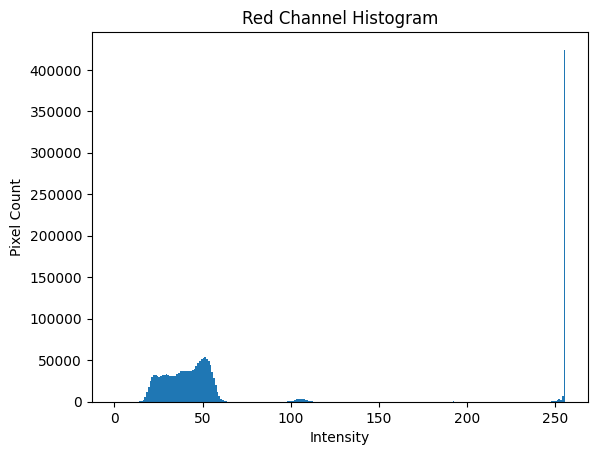

In [ ]:
## image check
import cv2
import numpy as np

img_bgr = cv2.imread("/content/drive/MyDrive/Data/output/35mm_18mm_900.jpeg", cv2.IMREAD_COLOR)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
red_channel = img_rgb[:, :, 0]
print("Max Red:", red_channel.max())
print("Mean Red:", red_channel.mean())
print("Min Red:", red_channel.min())
import matplotlib.pyplot as plt

plt.hist(red_channel.ravel(), bins=256, range=(0,256))
plt.title("Red Channel Histogram")
plt.xlabel("Intensity")
plt.ylabel("Pixel Count")
plt.show()

Dataset size: 49 samples


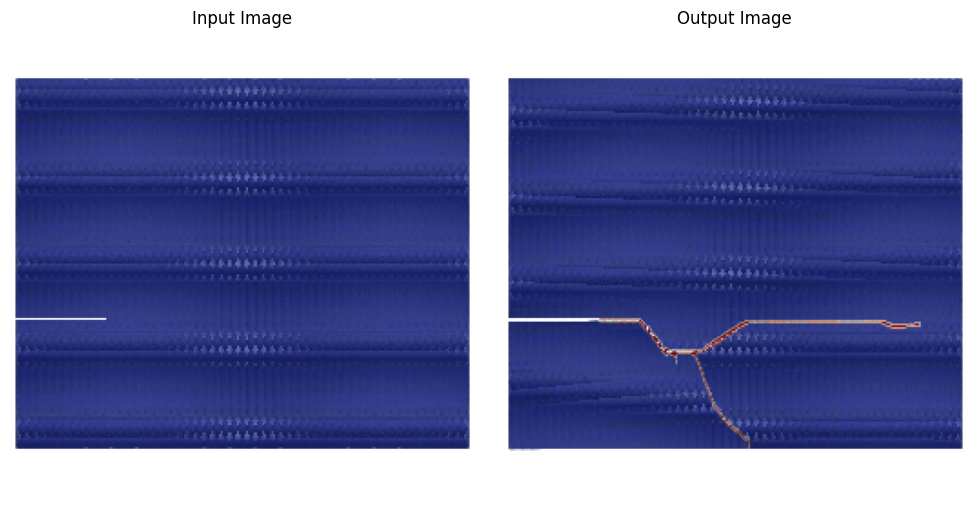

Training samples: 39, Validation samples: 10
Model has 7,760,163 trainable parameters.
Epoch [1/200], Train Loss: 0.1058, Val Loss: 0.0949
Model saved at epoch 1 with val_loss: 0.0949
Epoch [2/200], Train Loss: 0.0522, Val Loss: 0.0190
Model saved at epoch 2 with val_loss: 0.0190
Epoch [3/200], Train Loss: 0.0120, Val Loss: 0.0070
Model saved at epoch 3 with val_loss: 0.0070
Epoch [4/200], Train Loss: 0.0058, Val Loss: 0.0045
Model saved at epoch 4 with val_loss: 0.0045
Epoch [5/200], Train Loss: 0.0045, Val Loss: 0.0040
Model saved at epoch 5 with val_loss: 0.0040
Epoch [6/200], Train Loss: 0.0039, Val Loss: 0.0036
Model saved at epoch 6 with val_loss: 0.0036
Epoch [7/200], Train Loss: 0.0035, Val Loss: 0.0032
Model saved at epoch 7 with val_loss: 0.0032
Epoch [8/200], Train Loss: 0.0031, Val Loss: 0.0030
Model saved at epoch 8 with val_loss: 0.0030
Epoch [9/200], Train Loss: 0.0029, Val Loss: 0.0029
Model saved at epoch 9 with val_loss: 0.0029
Epoch [10/200], Train Loss: 0.0028, Val 

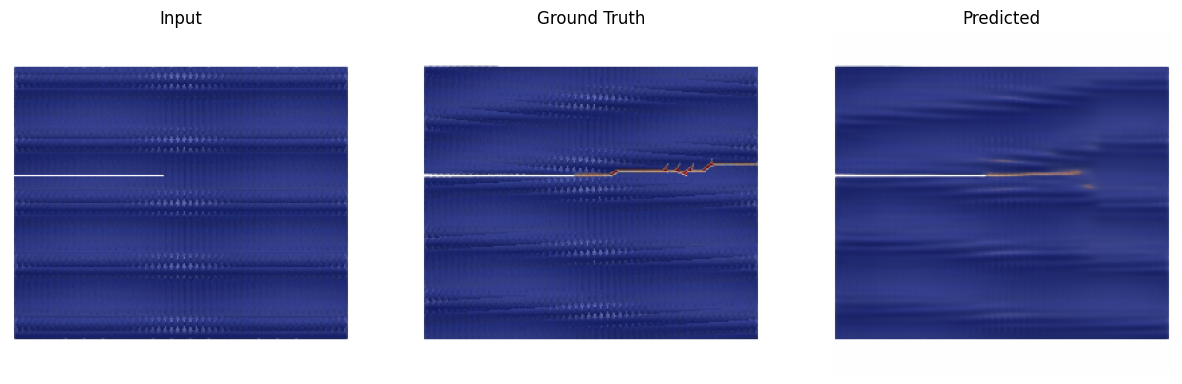

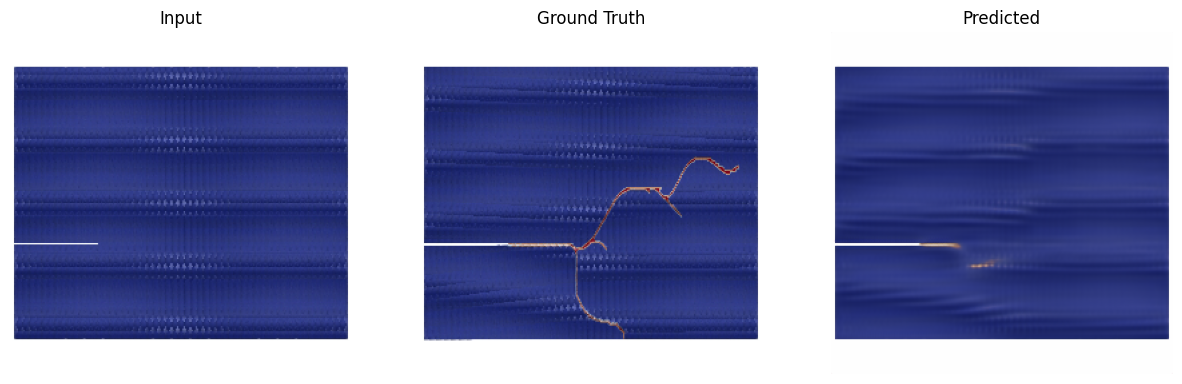

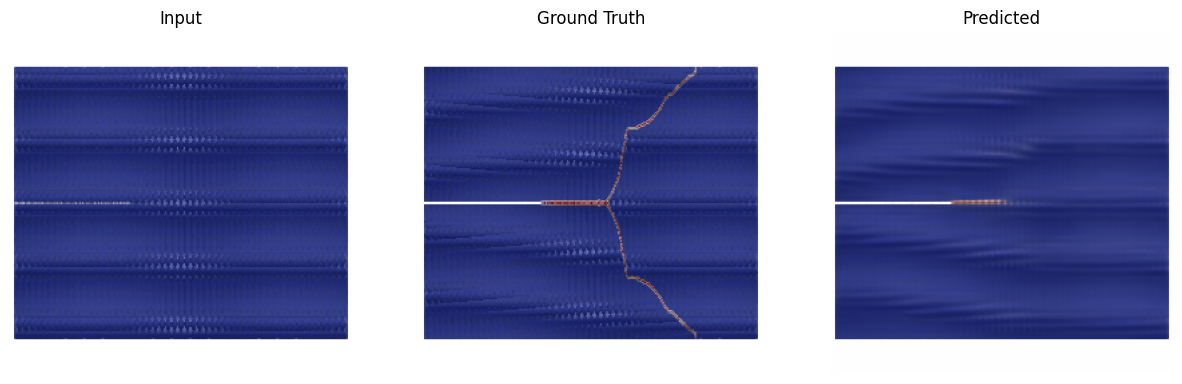

In [ ]:
# =========================
# Complete Code for Image-to-Image Crack Propagation Prediction using U-Net with MSE Loss
# =========================

# 1. Import required libraries
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt

# 2. Define the custom dataset class
class CrackDataset(Dataset):
    def __init__(self, input_dir, output_dir, target_size=(256, 256)):
        """
        input_dir: directory containing input images (initial crack configurations)
        output_dir: directory containing output images (propagation results)
        target_size: tuple, target image dimensions (width, height)
        """
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.input_files = sorted(os.listdir(input_dir))
        self.output_files = sorted(os.listdir(output_dir))
        self.target_size = target_size
        # Ensure that the number of files in both folders match
        assert len(self.input_files) == len(self.output_files), "Number of input and output files do not match!"

    def __len__(self):
        return len(self.input_files)

    def __getitem__(self, idx):
        # Build full paths
        input_path = os.path.join(self.input_dir, self.input_files[idx])
        output_path = os.path.join(self.output_dir, self.output_files[idx])
        # Read images in color (BGR) using OpenCV
        input_img = cv2.imread(input_path, cv2.IMREAD_COLOR)
        output_img = cv2.imread(output_path, cv2.IMREAD_COLOR)
        if input_img is None or output_img is None:
            raise ValueError(f"Error reading image pair: {self.input_files[idx]} and/or {self.output_files[idx]}")
        # Convert images from BGR to RGB
        input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
        output_img = cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)
        # Resize images to target dimensions
        input_img = cv2.resize(input_img, self.target_size)
        output_img = cv2.resize(output_img, self.target_size)
        # Normalize images to [0, 1]
        input_img = input_img.astype(np.float32) / 255.0
        output_img = output_img.astype(np.float32) / 255.0
        # Convert from HWC to CHW format
        input_img = np.transpose(input_img, (2, 0, 1))
        output_img = np.transpose(output_img, (2, 0, 1))

        sample = {
            'input': torch.tensor(input_img, dtype=torch.float32),
            'output': torch.tensor(output_img, dtype=torch.float32)
        }
        return sample

    def visualize_sample(self, idx):
        sample = self[idx]
        inp = sample['input'].permute(1, 2, 0).numpy()
        out = sample['output'].permute(1, 2, 0).numpy()

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(inp)
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(out)
        plt.title("Output Image")
        plt.axis("off")
        plt.tight_layout()
        plt.show()

# 3. Define a simple U-Net model for image-to-image mapping
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=[32, 64, 128, 256]):
        super(UNet, self).__init__()
        # Encoder
        self.encoder1 = self.double_conv(in_channels, features[0])
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.encoder2 = self.double_conv(features[0], features[1])
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.encoder3 = self.double_conv(features[1], features[2])
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.encoder4 = self.double_conv(features[2], features[3])
        self.pool4 = nn.MaxPool2d(kernel_size=2)

        # Bottleneck
        self.bottleneck = self.double_conv(features[3], features[3]*2)

        # Decoder
        self.upconv4 = nn.ConvTranspose2d(features[3]*2, features[3], kernel_size=2, stride=2)
        self.decoder4 = self.double_conv(features[3]*2, features[3])
        self.upconv3 = nn.ConvTranspose2d(features[3], features[2], kernel_size=2, stride=2)
        self.decoder3 = self.double_conv(features[2]*2, features[2])
        self.upconv2 = nn.ConvTranspose2d(features[2], features[1], kernel_size=2, stride=2)
        self.decoder2 = self.double_conv(features[1]*2, features[1])
        self.upconv1 = nn.ConvTranspose2d(features[1], features[0], kernel_size=2, stride=2)
        self.decoder1 = self.double_conv(features[0]*2, features[0])

        self.conv_final = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder pathway
        e1 = self.encoder1(x)       # [B, features[0], H, W]
        e2 = self.encoder2(self.pool1(e1))  # [B, features[1], H/2, W/2]
        e3 = self.encoder3(self.pool2(e2))  # [B, features[2], H/4, W/4]
        e4 = self.encoder4(self.pool3(e3))  # [B, features[3], H/8, W/8]

        # Bottleneck
        b = self.bottleneck(self.pool4(e4)) # [B, features[3]*2, H/16, W/16]

        # Decoder pathway
        d4 = self.upconv4(b)              # upsample to H/8, W/8
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.decoder4(d4)

        d3 = self.upconv3(d4)             # upsample to H/4, W/4
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.decoder3(d3)

        d2 = self.upconv2(d3)             # upsample to H/2, W/2
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.decoder2(d2)

        d1 = self.upconv1(d2)             # upsample to H, W
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.decoder1(d1)

        out = self.conv_final(d1)
        out = torch.sigmoid(out)  # output values in [0,1]
        return out

# 4. Utility function to count trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# 5. Set up dataset, dataloader, model, optimizer, and scheduler
# Update these paths with the location of your actual data
input_dir = '/content/drive/MyDrive/Data/input'
output_dir = '/content/drive/MyDrive/Data/output'

# Create the dataset
dataset = CrackDataset(input_dir, output_dir, target_size=(256, 256))
print(f"Dataset size: {len(dataset)} samples")

# Optionally, visualize one sample
dataset.visualize_sample(0)

# Split into training and validation sets (80% training, 20% validation)
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

# Create DataLoaders
batch_size = 4  # Adjust based on your GPU memory
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Instantiate the model and move to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(in_channels=3, out_channels=3).to(device)
print(f"Model has {count_parameters(model):,} trainable parameters.")

# Define the loss function and optimizer
criterion = nn.MSELoss()  # MSE loss for image reconstruction
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

# 6. Training Loop
num_epochs = 200
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        inputs = batch['input'].to(device)    # shape [B, 3, 256, 256]
        targets = batch['output'].to(device)    # shape [B, 3, 256, 256]

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            inputs = batch['input'].to(device)
            targets = batch['output'].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
    val_loss /= len(val_loader.dataset)

    scheduler.step(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Save the best model (if validation loss improved)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_crack_model.pth')
        print(f"Model saved at epoch {epoch+1} with val_loss: {val_loss:.4f}")

    # Optional early stopping criterion: for example, if learning rate becomes very low
    if epoch > 10 and optimizer.param_groups[0]['lr'] < 1e-5:
        print("Early stopping due to learning rate reduction.")
        break

# 7. Visualization of Predictions on Validation Set
def visualize_predictions(model, loader, num_samples=3):
    model.eval()
    device = next(model.parameters()).device
    samples_shown = 0
    with torch.no_grad():
        for batch in loader:
            inputs = batch['input'].to(device)
            targets = batch['output'].to(device)
            outputs = model(inputs)
            for i in range(inputs.size(0)):
                if samples_shown >= num_samples:
                    return
                inp_img = inputs[i].cpu().permute(1, 2, 0).numpy()
                true_img = targets[i].cpu().permute(1, 2, 0).numpy()
                pred_img = outputs[i].cpu().permute(1, 2, 0).numpy()

                fig, axs = plt.subplots(1, 3, figsize=(15, 5))
                axs[0].imshow(inp_img)
                axs[0].set_title("Input")
                axs[0].axis("off")

                axs[1].imshow(true_img)
                axs[1].set_title("Ground Truth")
                axs[1].axis("off")

                axs[2].imshow(pred_img)
                axs[2].set_title("Predicted")
                axs[2].axis("off")
                plt.show()
                samples_shown += 1

# Visualize a few predictions from the validation set
print("Visualizing predictions on validation set:")
visualize_predictions(model, val_loader, num_samples=3)
